### Instrucciones generales <a class="tocSkip"></a>
1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*
1. Se evaluará 
    1. el **resultado y la calidad de su implementación** en base al último commit antes de la fecha y hora de entrega
    1. su **proceso de desarrollo** en base a su histórico de commits
1. [Sean honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish)

# Tarea 3: Los K-vecinos 

![vecinos.png](https://i.imgur.com/qi04vM6.png)

Los $K$-vecinos es un método clásico de aprendizaje de máquinas para hacer clasificación

Sea una base de datos $E = \{(x_j, y_j), j=1, \ldots, N\}$, con $N$ ejemplos donde $x_j \in \mathbb{R}^{D}$ es un atributo d-dimensional e $y_j \in \{0, 1, 2, \ldots, C\}$ son sus etiquetas de clase

Sea ahora una segunda base de datos $T = \{(z_i), i=1, \ldots, M\}$ con $M$ ejemplos donde $z_i \in \mathbb{R}^{D}$ es un atributo d-dimensional. Esta base de datos no tiene etiquetas

> Este método clasifica cada elemento de $T$ en base a las etiquetas de sus $K$ ejemplos más cercanos de la base de datos $E$



Para clasificar el i-esimo elemento de Z:
1. Calculamos la distancia entre $z_i$ y cada elemento de $E$ usando
$$
d(z_i, x_j) = \left ( \sum_{d=1}^D  |z_{id} - x_{jd}|^p \right)^{1/p}
$$
1. Buscamos las $k$ tuplas $(x_k^{(i)}, y_k^{(i)})$ con menor distancia a $z_i$
1. Seleccionamos la clase de $z_i$ según
$$
\text{arg}\max_{c=0, 1, \ldots} \sum_{k=1}^K \frac{\mathbb{1}(c=y^{(i)}_k)}{d(z_i, x^{(i)}_k)}
$$
donde 
$$
\mathbb{1}(a=b) = \begin{cases} 1 & \text{si } a=b \\ 0 &  \text{si } a\neq b \end{cases}
$$
se conoce como función indicadora

Esta versión particular del algoritmo se conoce como clasificador de $k$ vecinos ponderado

# Actividades

- Considere la implementación "inocente" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto
    - Use la función adjunta `create_data` para crear un conjunto de N=1000 datos
    - Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`
    - Reporte sus resultados y comente sobre los cuellos de botella del algoritmo
- Implemente una nueva versión de la función `KNN`
    - Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`
    - Muestre que obtiene el mismo resultado que la versión original
    - Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$
- Usando la nueva versión de `KNN` y un conjunto de $1000$ datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$
- Evalue su clasificador en el conjunto $T$ y haga un reporte completo de resultados. Muestre una gráfica de la frontera de decisión de su clasificador en el rango $[(-2,2), (-2,2)]$

**Justifique adecuadamente todas sus decisiones de diseño**

# Ejemplo generación de datos

<IPython.core.display.Javascript object>


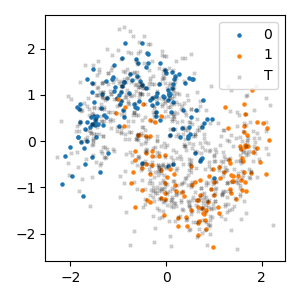

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

fig, ax = plt.subplots(figsize=(3, 3), tight_layout=True)
E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=c, s=5)
z, w = T # Use las etiquetas w para evaluar sus resultados finales
ax.scatter(z[:, 0], z[:, 1], c='k', s=5, marker='x',  alpha=0.2, label='T')
ax.legend();

# KNN de sklearn

Para obtener un objetivo a alcanzar para nuestra versión optimizada de KNN, podemos utilizar `KNeighborsClassifier` de `sklearn.neighbors` y medir su tiempo de ejecución con la misma entrada.
En primer lugar instanciamos el clasificador con las mismas características que la función `KNN inocente` que fue proporcionada:

In [2]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance',
                             algorithm='brute', p=2, n_jobs=1)

Medimos el tiempo de ajuste y predicción, para luego almacenarlo en la variable `totalTimeSklearn`

In [3]:
%%timeit -r 10 -n 10 -o 
neigh.fit(x, y)
neigh.predict(z)

The slowest run took 6.57 times longer than the fastest. This could mean that an intermediate result is being cached.
8.36 ms ± 8.93 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 8.36 ms ± 8.93 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [7]:
totalTimeSklearn = _

Comparamos los resultados de las predicciones para los dos algoritmos:

In [4]:
zySklearn = neigh.predict(z)
zy = KNN(x, y, z, k=5, p=2.)
display(np.allclose(zy, zySklearn))
#mask = zy - zySklearn != 0

True

Observamos que la implementación inocente de KNN y el ajuste de KNeighborsClassifier nos entregan las mismas predicciones. Para comparar, medimos el tiempo de ejecución de la implementación naive:

In [5]:
totalTimeNaive = %timeit -r 10 -n 1 -o KNN(x, y, z, k=5, p=2.)

2.05 s ± 316 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


Si bien no esperamos competir en rendimiento contra una librería especializada, este resultado nos da una idea del potencial speed-up que podríamos alcanzar. Por otra parte, tener disponible una versión rápida nos ayudará al momento de hacer pruebas con nuestras versiones optimizadas, sobretodo cuando queramos verificar que los resultados son correctos y estemos procesandoventradas relativamente grandes, permitiéndonos hacer comparaciones sin tener que esperar tanto tiempo por los resultados de la version inocente.

In [8]:
print(f"speedup knn naive / knn_skl:\n{totalTimeNaive.average / totalTimeSklearn.average : .3f}")

speedup knn naive / knn_skl:
 244.684


# 1- Realice un profiling completo de la función KNN usando las magias timeit, prun y lprun

### Tiempo total de la función KNN con la magia `%timeit` (previamente calculado)

In [9]:
display(totalTimeNaive)
print(f"min : {totalTimeNaive.best:.3f}[s], max: {totalTimeNaive.worst:.3f}[s]")

<TimeitResult : 2.05 s ± 316 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

min : 1.852[s], max: 2.929[s]


El tiempo que tarda la implementación inocente en ajustar y predecir para una entrada de tanaño N=1000 varía entre 1 y 20 segundos dependiendo de la máquina en la que realicemos las pruebas

### Cantidad de llamadas y el tiempo de cada función ejecutada por `KNN` utilizando la magia `%prun`

In [10]:
%prun -s tottime KNN(x, y, z, k=5, p=2.)

De este profiling se observa la gran cantidad de funciones que son llamadas dentro del primer ciclo for anidado, o sea, la linea 21 de `funciones.py` que se ejecuta N * M veces.


```python
dist[i, j] = np.power(np.sum(np.power(np.absolute(Z[i] - X[j]), p)), 1./p)
```

Probablemente sea esta linea el principal contribuyente al tiempo que tarda el algoritmo.

Aparte del primer ciclo for anidado destaca la linea  `  1    0.012    0.012    0.012    0.012 {method 'argsort' of 'numpy.ndarray' objects}` con el mayor tiempo por llamada, sin embargo sólo se llama una vez, por lo que no nos parece la mejor opción enfocar nuestros esfuerzos en la implementación de un algoritmo argsort que nos ofrecerá una mejora marginal en comparación a optimizar la sección que se ejecuta muchas veces.

### Profiling línea a línea con `%lprun`

In [11]:
%load_ext line_profiler

In [12]:
lineProf = %lprun -r -f KNN KNN(x, y, z, k=5, p=2.)

In [13]:
lineProf.print_stats()

Timer unit: 1e-06 s

Total time: 3.16465 s
File: /home/fernando/Documentos/final/INFO147_TAREA03/funciones.py
Function: KNN at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
    14                                           def KNN(X, Y, Z, k=5, p=2.):
    15         1         83.0     83.0      0.0      C = np.unique(Y)
    16         1          1.0      1.0      0.0      N, D = X.shape
    17         1          1.0      1.0      0.0      M, _ = Z.shape
    18         1        214.0    214.0      0.0      dist = np.zeros(shape=(M, N))
    19       751        459.0      0.6      0.0      for i in range(M):
    20    188250     122265.0      0.6      3.9          for j in range(N):
    21    187500    2999877.0     16.0     94.8              dist[i, j] = np.power(np.sum(np.power(np.absolute(Z[i] - X[j]), p)), 1./p)
    22         1       7694.0   7694.0      0.2      neighbours = np.argsort(dist, axis=1)[:, :k]
    23         1          7.0      7.0      0.0     

Como sospechábamos, un enorme margen del tiempo total de ejecución se debe a la línea que calcula y almacena la distancia entre cada par de datos que, junto a su respectivo `for` **acumulan cerca del 98% del total del tiempo de ejecución:**


```python
20) for j in range(N):
21)    dist[i, j] = np.power(np.sum(np.power(np.absolute(Z[i] - X[j]), p)), 1./p)
```


Principalmente la línea (21) con más del 94% del total, línea que llamó nuestra atención en el profiling previo por todas las llamadas a funciones que realiza debido a los numerosos cálculos matemáticos complejos que efectúa.

```python
27) for j in range(N):
    criterion[c] = np.sum(1./dist[i, neighbours[i]][Y[neighbours[i]] == c])
```

Del mismo modo intentaremos optimizar la línea 27 que se encuentra en segundo lugar en tiempo total, aunque su tiempo de ejecución parezca despreciable si lo comparamos con el de la línea 21.

Con esto en mente, buscaremos optimizar la problemática línea 21, y la función en general, con el fin de reducir el tiempo de ejecución del algoritmo. Para esto, utilizaremos **Cython** aplicando las mejoras que aprendimos en el curso como el uso de **tipos estáticos** y de **funciones nativas de C** para los cálculos matemáticos.

Esperamos que, a medida que optimicemos ciertas secciones del código, descubramos otros cuellos de botella u otras partes que nos entreguen mejoras menores en rendimiento.

# Utilice Cython con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de C

In [14]:
%load_ext cython
from Cython.Compiler import Options
Options.get_directive_defaults()['profile'] = True
Options.get_directive_defaults()['linetrace'] = True
Options.get_directive_defaults()['binding'] = True

%%cython -a --compile-args=-DCYTHON_TRACE=1 --force

### KNN Cython C

In [15]:
%%cython -a -c=-DCYTHON_TRACE=1 --force
import numpy as np
cimport cython
cimport numpy as npc
from libc.stdlib cimport qsort

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h":
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)
    
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;   

cdef IndexedDist make_item(TIPO_t value, TIPO_i index):
    cdef IndexedDist foo 
    foo.value = value
    foo.index = index
    return foo    
    
cdef int cmp_func(const void* a, const void* b) nogil:
    return ((<IndexedDist*>a).value > (<IndexedDist*>b).value) - ((<IndexedDist*>a).value < (<IndexedDist*>b).value)
  
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_C(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        Py_ssize_t nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        size_t tamano = sizeof(IndexedDist)
        TIPO_t eps = 0.00001
        
    #si no hay suficientes vecinos, buscar los (maximos) cercanos 
    if k > N:
        k = N
    
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
    
    for i in range(M):
        for j in range(N):
            dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
            for l in range(1, D):
                dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
            dist_view[i, j].value = pow(dist_view[i, j].value, exponent)

    for i in range(M):
        qsort(&dist_view[i][0], N, tamano, cmp_func)
    
    Zz_Y = np.empty(shape=(M, ), dtype=TIPI)
    
    cdef:
        TIPO_i [::1] Z_Y = Zz_Y
        TIPO_t valmax, criterion
        
    for i in range(M):
        valmax = 0.
        for j in range(nUniques):
            criterion = 0.
            for l in range(k):
                criterion += (Y[dist_view[i][l].index] == C[j])/(dist_view[i, l].value + eps)
            if valmax < criterion:
                Z_Y[i] = j
                valmax = criterion
    return Zz_Y

### Justificaciones de las modificaciones realizadas.

- se usaron los keyword *tipo_t* y *tipo_i* para tener distintas versiones del codigo para distintos tipos de entrada.


- Se definieron tipos estaticos para evitar el  **overhead** de python en las variables y arreglos con el keyword `cdef` como por ejemplo:
```python
cdef IndexedDist [:, ::1] dist_view = dist
TIPO_t valmax, criterion
```

- Para reducir la cantidad de llamadas a las funciones de python, y en particular, para incorporar la funcionalidad de np.argsort, sólo con librerías de C, se creó una estructura que almacena la distancia entre dos elementos, y el índice (j/columna o x asociado a un par) correspondiente.
argsort
```python
neighbours = np.argsort(dist, axis=1)[:, :k]
```
estructura:
```python
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;
```
Con esta estructura, podemos ordenar las filas de la matriz con la función `qsort` de C para luego obtener los k elementos de menor distancia, y acceder fácilmente al índice original cuando necesitemos determinar la clase de un elemento de salida.
```python
cdef int cmp_func(const void* a, const void* b) nogil:
#qsort de C
qsort(&dist_view[i][0], N, tamano, cmp_func)
#acceder al indice original
criterion += (Y[dist_view[i][l].index] == C[j])/(dist_view[i, l].value)
```

- Los arreglos utilizados dentro de las funciones se inicializaron vacíos o con ceros con numpy, pero los accesos y modificaciones se hicieron a través de sus respectivas copias como memory-view row major:
```python
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
```

- Para evitar aplicar funciones de numpy a los *memory-view* se importaron funciones matemáticas nativas de C y así igual que el caso anterior reducir las llamadas al interprete de python, estas funciones de C fueron *pow* y *fabs*
```python
dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
```


- Se guardo el exponente para evitar calcularlo todas las veces, así como otros elementos que se podrían calcular más de una vez pero cuyo valor es constante: 
```python
TIPO_t exponent = 1/p
```
```python
#largo de C
criterion = np.zeros(shape=(len(C),))
int nUniques = Cn.shape[0]
size_t tamano = sizeof(IndexedDist)
```

- Se desactivaron las verificaciones de *boundscheck* y *wraparound* y *cdivision* ya que sólo utilizamos índices positivos y no realizamos operaciones sobre estos.
```python
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
```
- Se incorporó una variable valmax y que guarda al valor maximo y se actualiza cuando se encuentra un `criterion` mayor para así evitar usar la funcion de numpy *np.argmax()*
```python
if valmax < criterion:
    Z_Y[i] = j
    valmax = criterion
```

Con todos estos cambios, la cantidad de "líneas amarillas" se redujo notablemente...

#### Profilling de la versión C

In [17]:
import line_profiler
profileC = line_profiler.LineProfiler(KNN_C)
profileC.runcall(KNN_C, x, y, z, k=5, p=2.)
profileC.print_stats()

Timer unit: 1e-06 s

Total time: 0.377253 s
File: /home/fernando/.cache/ipython/cython/_cython_magic_a56dbb61a47921baee6351d975d1f6ed.pyx
Function: KNN_C at line 32

Line #      Hits         Time  Per Hit   % Time  Line Contents
    32                                           def KNN_C(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    33                                               
    34         1        242.0    242.0      0.1      Cn = np.unique(Y)
    35                                               cdef:
    36         1         15.0     15.0      0.0          TIPO_i [::1] C = Cn
    37         1          4.0      4.0      0.0          Py_ssize_t nUniques = Cn.shape[0]
    38         1          1.0      1.0      0.0          Py_ssize_t N = X.shape[0]
    39         1          1.0      1.0      0.0          Py_ssize_t D = X.shape[1]
    40         1          1.0      1.0      0.0          Py_ssize_t M = Z.shape[0]
    41                        

Observando la distribución de los tiempos de ejecución de la función, vemos que la linea que destacó en el profiling de la versión inocente sigue acaparando un gran porcentaje del tiempo total, solo que ahora se encuentra en separada en 4:
```python
#%Time (referencial)
38.5              dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
17.3              for l in range(1, D):
18.5                  dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
18.2              dist_view[i, j].value = pow(dist_view[i, j].value, exponent)
```


Sabemos que calcular las distancias para una fila $i$ no depende de los resultados de otra fila, es por esto que podemos paralelizar este proceso sin mayor dificultad. Podemos hacer lo mismo con la linea $56$, que, luego de los cambios realizados, pasó a utilizar cerca de un 5% del tiempo total. 

```python
#%Time (referencial)
5.9          qsort(&dist_view[i][0], N, tamano, cmp_func)
```

### KNN Cython C con paralelismo

In [18]:
%%cython -a -c=-DCYTHON_TRACE=1 -c=-fopenmp --link-args=-fopenmp --force
import numpy as np
cimport cython
cimport numpy as npc
from libc.stdlib cimport qsort
from cython.parallel import prange

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h" nogil:
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)
    
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;   

cdef IndexedDist make_item(TIPO_t value, TIPO_i index) nogil:
    cdef IndexedDist foo 
    foo.value = value
    foo.index = index
    return foo    
    
cdef int cmp_func(const void* a, const void* b) nogil:
    return ((<IndexedDist*>a).value > (<IndexedDist*>b).value) - ((<IndexedDist*>a).value < (<IndexedDist*>b).value)
  
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_C_par(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        Py_ssize_t nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        size_t tamano = sizeof(IndexedDist)
        TIPO_t eps = 0.00001
        
    #si no hay suficientes vecinos, buscar los (maximos) cercanos 
    if k > N:
        k = N
    
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
    
    with nogil:
        for i in prange(M, num_threads=4):
            for j in range(N):
                dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
                for l in range(1, D):
                    dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
                dist_view[i, j].value = pow(dist_view[i, j].value, exponent)

    with nogil:
        for i in prange(M, num_threads=4):
            qsort(&dist_view[i][0], N, tamano, cmp_func)
    
    Zz_Y = np.empty(shape=(M, ), dtype=TIPI)
    
    cdef:
        TIPO_i [::1] Z_Y = Zz_Y
        TIPO_t valmax, criterion
        
    for i in range(M):
        valmax = 0.
        for j in range(nUniques):
            criterion = 0.
            for l in range(k):
                criterion += (Y[dist_view[i][l].index] == C[j])/(dist_view[i, l].value + eps)
            if valmax < criterion:
                Z_Y[i] = j
                valmax = criterion
    return Zz_Y

#### Profiling de la versión C con paralelismo

In [19]:
profileCpar = line_profiler.LineProfiler(KNN_C_par)
profileCpar.runcall(KNN_C_par, x, y, z, k=5, p=2.)
profileCpar.print_stats()

Timer unit: 1e-06 s

Total time: 0.117656 s
File: /home/fernando/.cache/ipython/cython/_cython_magic_048e84b057503721e563c4868174db2d.pyx
Function: KNN_C_par at line 33

Line #      Hits         Time  Per Hit   % Time  Line Contents
    33                                           def KNN_C_par(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    34                                               
    35         1       1274.0   1274.0      1.1      Cn = np.unique(Y)
    36                                               cdef:
    37         1         31.0     31.0      0.0          TIPO_i [::1] C = Cn
    38         1          4.0      4.0      0.0          Py_ssize_t nUniques = Cn.shape[0]
    39         1          1.0      1.0      0.0          Py_ssize_t N = X.shape[0]
    40         1          2.0      2.0      0.0          Py_ssize_t D = X.shape[1]
    41         1          1.0      1.0      0.0          Py_ssize_t M = Z.shape[0]
    42                

**Paralelismo con fopenmp y 4 threads**

```python
with nogil:
    for i in prange(M, num_threads=4):
```


La incorporacion de paralelismo  a nuestra funcion KNN_C trajo consigo cambios importantes en cuanto a los porcentajes de tiempos de ejecución: el primer ciclo for, encargado de calcular las distancias, redujo su y tiempo total y porcentaje en **alrededor de un 50%**, develando tiempos significativos en las lineas que anteriormente figuraban con valores muy cercanos o derechamente iguales a cero como algunos `cdef`. 

Otro resultado interesante fue el notable incremento en el porcentaje de tiempo correspondiente a al ordenamiento con `qsort`, que alcanzó un valor cercano al total de calculos de distancias.

**Comparación de resultados lprun C vs C_par entrada tamaño N=1000**

```python
#Ttotal    #perCall    %
174795.0    233.1      5.6      qsort(&dist_view[i][0], N, tamano, cmp_func)
```

```python
#Ttotal     %
106451.0     39.4      with nogil: 
                            for i in prange(M, num_threads=4):
                                qsort(&dist_view[i][0], N, tamano, cmp_func)
```

Vemos que el tiempo total que tardaba `qsort` tambien se redujo, pero en menor medida en comparación al punto mencionado anteriormente.

**Prediccion de la etiqueta**

Cabe destacar que también realizamos pruebas paralelizando el ciclo for que genera el arreglo a retornar (el que se encuentra abajo), pero los resultados fueron iguales o peores que sin paralelismo, al menos para entradas <= 10000. Para las otras dos incorporaciones de paralelismo, el gráfico de speed-up que se encuentra más adelante en el cuadernillo muestra a partir de qué tamaño de la entrada la versión parelizada es superior.

```python
#predicción de las etiquetas
for i in range(M):
    valmax = 0.
    for j in range(nUniques):
        ...
```



# Implementación compilando para C++ y utilizando sort() de std algorithm

Ya que Cython también permite compilar código para C++, en la búsqueda de la implementación más rápida decidimos probar el rendimiento del algoritmo de ordenamiento `sort()` de std algorithm. Salvo el mencionado algoritmo y la función de comparación que utiliza, las versiones C  y C++ son idénticas.

### KNN Cython C++

In [20]:
%%cython -+ -c=-DCYTHON_TRACE=1 --force
import numpy as np
cimport cython
cimport numpy as npc
from cython.parallel import prange
from libcpp.algorithm cimport sort as stdsort
from libcpp cimport bool

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h" nogil:
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)
    
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;
    
cdef bool comp(IndexedDist a, IndexedDist b):
    return (a.value < b.value)   

cdef IndexedDist make_item(TIPO_t value, TIPO_i index):
    cdef IndexedDist foo
    foo.value = value
    foo.index = index
    return foo    
      
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_CPP(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        Py_ssize_t nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        TIPO_t eps = 0.00001
        
    #si no hay suficientes vecinos, buscar los (maximos) cercanos 
    if k > N:
        k = N
    
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
    
    for i in range(M):
        for j in range(N):
            dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
            for l in range(1, D):
                dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
            dist_view[i, j].value = pow(dist_view[i, j].value, exponent)

    for i in range(M):
        stdsort(&(dist_view[i][0]), (&(dist_view[i][0])) +  N, comp)
    
    Zz_Y = np.empty(shape=(M, ), dtype=TIPI)
    
    cdef:
        TIPO_i [::1] Z_Y = Zz_Y
        TIPO_t valmax, criterion
        
    for i in range(M):
        valmax = 0.
        for j in range(nUniques):
            criterion = 0.
            for l in range(k):
                criterion += (Y[dist_view[i][l].index] == C[j])/(dist_view[i, l].value + eps)
            if valmax < criterion:
                Z_Y[i] = j
                valmax = criterion
    return Zz_Y

### KNN Cython C++ con paralelismo

In [21]:
%%cython -+ -c=-DCYTHON_TRACE=1 -c=-fopenmp --link-args=-fopenmp --force
import numpy as np
cimport cython
cimport numpy as npc
from cython.parallel import prange
from libcpp.algorithm cimport sort as stdsort
from libcpp cimport bool

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h" nogil:
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)
    
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;
    
cdef bool comp(IndexedDist a, IndexedDist b) nogil:
    return (a.value < b.value)   

cdef IndexedDist make_item(TIPO_t value, TIPO_i index) nogil:
    cdef IndexedDist foo
    foo.value = value
    foo.index = index
    return foo    
      
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_CPP_par(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        Py_ssize_t nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        TIPO_t eps = 0.00001
        
    #si no hay suficientes vecinos, buscar los (maximos) cercanos 
    if k > N:
        k = N
    
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
    
    with nogil:
        for i in prange(M, num_threads=4):
            for j in range(N):
                dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
                for l in range(1, D):
                    dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
                dist_view[i, j].value = pow(dist_view[i, j].value, exponent)
        
    with nogil:
        for i in prange(M, num_threads=4):
            stdsort(&dist_view[i][0], (&(dist_view[i][0])) +  N, comp)
    
    Zz_Y = np.empty(shape=(M, ), dtype=TIPI)
    cdef:
        TIPO_i [::1] Z_Y = Zz_Y
        TIPO_t valmax, criterion
        
    for i in range(M):
        valmax = 0.
        for j in range(nUniques):
            criterion = 0.
            for l in range(k):
                criterion += (Y[dist_view[i][l].index] == C[j])/(dist_view[i, l].value + eps)
            if valmax < criterion:
                Z_Y[i] = j
                valmax = criterion
    return Zz_Y

# Muestre que obtiene el mismo resultado que la versión original

In [ ]:
functions = [KNN, KNN_C, KNN_CPP, KNN_C_par, KNN_CPP_par, neigh.predict, neigh_par.predict]
nValues = [10, 50, 100, 500, 1000, 5000, 10000]
sep = "-"*70
timeResults = np.empty(shape=(len(functions), len(nValues)))
stdResults = np.empty(shape=(len(functions), len(nValues)))

def updatePredict(vecinos=5, pval=2):
    neigh = KNeighborsClassifier(n_neighbors=vecinos, weights='distance',
                                 algorithm='brute', p=pval, n_jobs=1)

    neigh_par = KNeighborsClassifier(n_neighbors=vecinos, weights='distance',
                                 algorithm='brute', p=pval, n_jobs=4)
    return neigh, neigh_par
#la entrada n = 10 permite un max de 2 vecinos

In [ ]:
neigh, neigh_par = updatePredict(2, 2)
functions = [KNN, KNN_C, KNN_CPP, KNN_C_par, KNN_CPP_par, neigh.predict, neigh_par.predict]
for j, nVal in enumerate(nValues):
    E, T = create_data(N=nVal)
    x, y = E
    z, _ = T
    if nVal == 50:
        neigh, neigh_par = updatePredict(5, 2)
        functions[-2] = neigh.predict
        functions[-1] = neigh_par.predict
    neigh.fit(x, y)
    neigh_par.fit(x, y)
    todasClose = True
    res_inoc = KNN(x, y, z)
    print(f"Profiling tiempo de ejecución para entrada de tamaño {nVal} ...")
    for i, fun in enumerate(functions):
        if fun == KNN:          
            if nVal > 1000:
                timeR = %timeit -r 5 -n 1 -o -q fun(x, y, z)
            else:
                timeR = %timeit -r 10 -o -q fun(x, y, z)
        else:          
            if i > functions.index(KNN_CPP_par):
                params = (z,)
            else:
                params = (x, y, z)
            res_other = fun(*params)
            timeR = %timeit -r 10 -o -q fun(*params)
            if (not np.allclose(res_inoc, res_other)):
                todasClose = False
                print(f"{fun.__name__} arrojó un resultado distinto al de KNN.")     
        timeResults[i][j] = timeR.average
        stdResults[i][j] = timeR.stdev
    if todasClose:
        print("Todas las versiones generaron el mismo resultado que el de KNN.")
    print(sep)

Comprobamos que, para los tamaños de entrada dados, todas las funciones utilizadas entregan el mismo resultado que el de la versión original.

# Grafique el speed-up de su nueva función con respecto a la implementación "inocente" original para 𝑁=[10,50,100,500,1000,5000,10000]

Primero calculamos el speed-up con los datos que obtuvimos en el item anterior:

In [25]:
#la primera funcion debe ser knn inocente
speedUp = np.empty(shape=(len(functions), len(nValues)))
for j, nval in enumerate(nValues):
    for i, fun in enumerate(functions):
        speedUp[i][j] = (timeResults[0][j]/ timeResults[i][j])

In [ ]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8, 6))
for i in range(1, speedUp.shape[0] - 2):
    lb = "speed-up con " + functions[i].func_name
    ax.plot(nValues, speedUp[i], label=lb)
    ax.scatter(nValues, speedUp[i])
     
ax.set_title("Speed-up respecto a la implementación inocente\npara entradas de distintos tamanos")
ax.set_ylabel("Speed-up")
ax.set_xlabel(" tamano N conjunto de entrada")
ax.legend()
ax.set_xticks(nValues)
ax.set_xscale('log')
ax.grid()

- En entradas pequeñas(N<50) se aprecia que la mejor funcion es *KNN_CPP*, mientras que la de peor desempeño es *KNN_C_par*.


- A medida que el tamaño de la entrada aumenta se empieza a observar un patron claro donde la funcion *KNN_CPP_par* es la que se desempeña de mejor manera con un *speed-up* que alcanza valores mayores a 200, le sigue *KNN_C_par*, *KNN_CPP* y para terminar *KNN_C* que es la que tiene un peor rendimiento para entradas grandes con valor de *speed-up* cercano a 50.

Crearemos un grafico con neigh.predict con njobs=1 y njobs=4 (neigh_par) para visualizar el comportamiento de las otras todas las funciones.

<IPython.core.display.Javascript object>


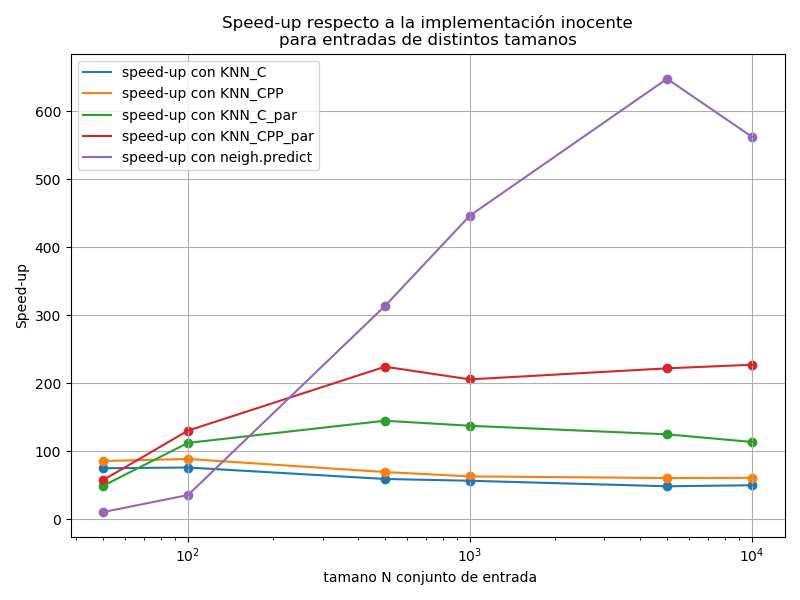

In [26]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8, 6))
for i in range(1, speedUp.shape[0] - 1):
    lb = "speed-up con " + functions[i].func_name
    ax2.plot(nValues, speedUp[i], label=lb)
    ax2.scatter(nValues, speedUp[i])
    
lb = "speed-up con neigh.predict"
ax2.plot(nValues, speedUp[-1], label=lb)
ax2.scatter(nValues, speedUp[-2])

lb = "speed-up con neigh_par.predict"
ax2.plot(nValues, speedUp[-1], label=lb)
ax2.scatter(nValues, speedUp[-1])
    
ax2.set_title("Speed-up respecto a la implementación inocente\npara entradas de distintos tamanos")
ax2.set_ylabel("Speed-up")
ax2.set_xlabel(" tamano N conjunto de entrada")
ax2.legend()
ax2.set_xticks(nValues)
ax2.set_xscale('log')
ax2.grid()

Para las entradas más grandes *neigh.predict* es más rapido que el resto de las funciones mientras que para las entradas mas pequeñas es la que peor rendimiento tiene.


# Usando la nueva versión de `KNN` y un conjunto de $1000$ datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$###

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold

E, T = create_data(N=1000)
x, y = E
z, _ = T

def validacion(fun):
    kf = KFold(n_splits=5) # 5 particiones
    pvalues = np.linspace(0.1, 15, num=150)
    scores = [[], [], [], []]
    for pv in pvalues:
        for kval in range(1, 20):
            score = np.zeros(shape=(kf.get_n_splits(), ))
            for i, (train_index, valid_index) in enumerate(kf.split(x)):
                score[i] = accuracy_score(y[valid_index],
                                     (fun(x[train_index],
                                          y[train_index],
                                          x[valid_index], 
                                          k=kval, p=pv)))
            for i, att in enumerate([pv, kval, np.mean(score), np.std(score)]):
                scores[i].append(att)

    idx = np.argmax(scores[2])
    bestParams = {}
    for listas, att in zip (scores, ["p", "k", "score", "std"]):
        bestParams[att] = listas[idx]
    return bestParams

In [1]:
bestT = 9999
for fun in [KNN_C, KNN_CPP, KNN_C_par, KNN_CPP_par]:
    print(f" Profiling de validacion con la función: {fun.__name__}")
    timeV = %timeit -r 3 -n 1 -o validacion(fun)
    if (timeV.average < bestT):
        bestT = timeV.average
        bestFun = fun
    print(sep)
print(f"la mejor funcion para la validacion es {bestFun.__name__}"
     +f" con un tiempo promedio de {bestT}[s]")

NameError: name 'KNN_C' is not defined

In [ ]:
bestParams = validacion(bestFun)
print(bestParams)

El mejor valor de los parámetros  𝑘  y  𝑝 son 1 y 13 respectivamente con una correctitud de 0.952 y desviacion estandar $\approx$ 0.02713

# Evalue su clasificador en el conjunto 𝑇 y haga un reporte completo de resultados. Muestre una gráfica de la frontera de decisión de su clasificador en el rango [(−2,2),(−2,2)]

### Matriz de confusión

<IPython.core.display.Javascript object>


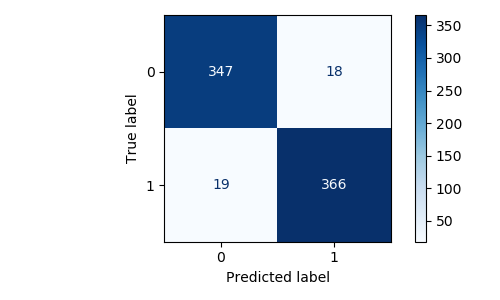

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

bestParams = validacion(KNN_CPP_par)
fig, ax3 = plt.subplots(figsize=(5, 3), tight_layout=True)
ypred = KNN_CPP_par(x, y, z, k=bestParams.get("k"), p=bestParams.get("p"))
cm = confusion_matrix(w, ypred)                     
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['0', '1']))
disp = disp.plot(include_values=True,
                 cmap=plt.cm.Blues, ax=ax3)

plt.show()

En ambos casos los casos predichos que pertenecen a la otra clase son parecidos en cantidad:

    -Hay 18 casos predichos como clase 1 que en realidad eran clase 0.

    -Hay 19 casos predichos como clase 0 que en realidad eran clase 1.

# Frontera de decisión del clasificador 

### Variación KNN Predict Proba en Cython C++

In [35]:
%%cython -+ -c=-fopenmp --link-args=-fopenmp --force
import numpy as np
cimport cython
cimport numpy as npc
from cython.parallel import prange
from libcpp.algorithm cimport sort as stdsort
from libcpp cimport bool

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h" nogil:
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)
    
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;
    
cdef bool comp(IndexedDist a, IndexedDist b) nogil:
    return (a.value < b.value)   

cdef IndexedDist make_item(TIPO_t value, TIPO_i index) nogil:
    cdef IndexedDist foo
    foo.value = value
    foo.index = index
    return foo    
      
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_CPP_par_proba(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        int nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        
    if N < k:
        k = N
    
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
    
    with nogil:
        for i in prange(M, num_threads=4):
            for j in range(N):
                dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
                for l in range(1, D):
                    dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
                dist_view[i, j].value = pow(dist_view[i, j].value, exponent)
        
    with nogil:
        for i in prange(M, num_threads=4):
            stdsort(&dist_view[i][0], (&(dist_view[i][0])) +  N, comp)
    
    Zz_Y = np.empty(shape=(M, nUniques), dtype=TIPO, order='C')
    crit = np.empty(shape=(nUniques, ), dtype=TIPO, order='C')
    cdef:
        TIPO_t [:, ::1] Z_Y = Zz_Y
        TIPO_t total
        TIPO_t [::1] criterion = crit
        
    for i in range(M):
        total = 0.
        for j in range(nUniques):
            criterion[j] = 0.
            for l in range(k):
                criterion[j] += (Y[dist_view[i, l].index] == C[j])/(dist_view[i, l].value)
            total += criterion[j]
        for j in range(nUniques):
            Z_Y[i, j] = criterion[j] / total
    return Zz_Y

<IPython.core.display.Javascript object>


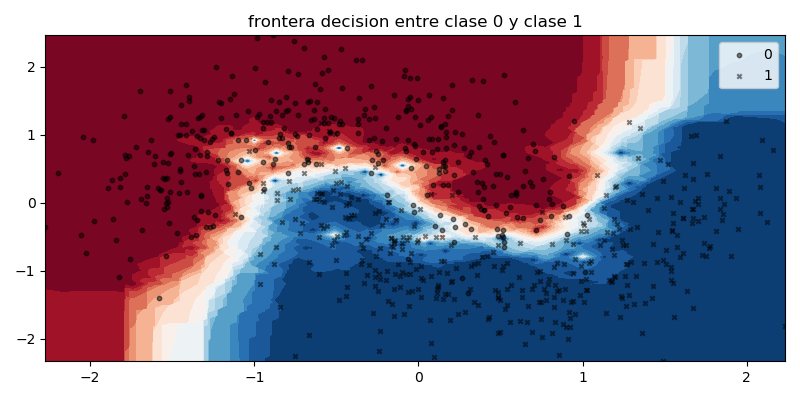

In [36]:
x_plot = np.linspace(np.amin(z[:, 0]), np.amax(z[:, 0]), num=750)
z_plot = np.linspace(np.amin(z[:, 1]), np.amax(z[:, 1]), num=750)

X, Z = np.meshgrid(x_plot, z_plot)

fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
for k, (label, marker) in enumerate(zip(['0', '1'], ['o', 'x'])):
    ax.scatter(z[w==k, 0], z[w==k, 1], c='k', s=10, 
               marker=marker, label=label, alpha=0.5)

Y2 = KNN_CPP_par_proba(x, y, np.array(np.stack((X.ravel(), Z.ravel())).T, order='c'), 
                                        k=bestParams.get("k"), p=bestParams.get("p"))[:, 1]
#cmap=plt.get_cmap(name)
cmap=plt.cm.RdBu
ax.contourf(X, Z, np.reshape(Y2, X.shape), zorder=-1, cmap=plt.cm.RdBu,
            vmin=0, vmax=1, levels=20)
ax.set_title("frontera decision entre clase 0 y clase 1")
ax.set_xlim([np.amin(x_plot), np.amax(x_plot)])
ax.set_ylim([np.amin(z_plot), np.amax(z_plot)])
plt.legend();

-Se asemeja a las 'lunas' que se mostraban arriba cuando graficabamos las entradas en el primer grafico.

-En la zona roja mas oscura se aprecia que los puntos pertenecen a la clase 0 y en la azul más oscuro a los puntos de clase 1. 

-La zona de incertiduble de color blanco es amplia y es donde no se tiene claro a que clase pertenece cada punto.
